In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ECommerceAnalysis").getOrCreate()


# Step 2: Import Functions & Load CSV Files

In this step, we import common Spark functions and load three CSV files into Spark DataFrames: customers, products, and orders.  
After loading, we display all three DataFrames to verify the data.


In [0]:
# Step 2: Import Functions & Load CSV Files
# Import common Spark functions like col, sum, avg, etc.
from pyspark.sql.functions import *

# Load customer data from DBFS
customers_df = spark.read.csv("/FileStore/tables/customers.csv", header=True, inferSchema=True)

# Load product data from DBFS
products_df  = spark.read.csv("/FileStore/tables/products.csv", header=True, inferSchema=True)

# Load orders data from DBFS
orders_df    = spark.read.csv("/FileStore/tables/orders.csv", header=True, inferSchema=True)

# Display all three DataFrames
display(customers_df)
display(products_df)
display(orders_df)


customer_id,name,city,age
1,Rahul Sharma,Bangalore,28
2,Priya Singh,Delhi,32
3,Aman Kumar,Hyderabad,25
4,Sneha Reddy,Chennai,35
5,Arjun Mehta,Mumbai,30
6,Divya Nair,Delhi,29


product_id,product_name,category,price
101,Laptop,Electronics,55000
102,Mobile,Electronics,25000
103,Headphones,Electronics,3000
104,Chair,Furniture,5000
105,Book,Stationery,700
106,Shoes,Fashion,2500


order_id,customer_id,product_id,quantity,order_date
1001,1,101,1,2024-01-10
1002,2,102,2,2024-01-12
1003,1,103,3,2024-02-05
1004,3,104,1,2024-02-08
1005,5,105,5,2024-03-01
1006,6,106,2,2024-03-15
1007,7,101,1,2024-03-20


# Step 3: Data Transformations

In this step, we perform several transformations on the orders data:  

- Join orders with products to include product details like price.  
- Add a `total_price` column calculated as `quantity * price`.  
- Filter orders where `total_price` is greater than 40,000.  
- Extract the month from the `order_date` column.  
- Sort orders by `total_price` in descending order.  
- Display the sorted orders to review the results.


In [0]:
# Step 3: Data Transformations

# Join orders with products to include product details like price
joined_df = orders_df.join(products_df, "product_id")

# Add total_price column = quantity * price
orders_total_df = joined_df.withColumn("total_price", col("quantity") * col("price"))

# Filter orders where total price > 40,000
high_value_orders = orders_total_df.filter(col("total_price") > 40000)

# Extract month from order_date column
orders_with_month = orders_total_df.withColumn("month", month(col("order_date")))

# Sort orders by total_price in descending order
sorted_orders = orders_total_df.orderBy(col("total_price").desc())

# Display the sorted orders
display(sorted_orders)


product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000
105,1005,5,5,2024-03-01,Book,Stationery,700,3500


# Step 4: Aggregations

In this step, we calculate various summary statistics from our data:  

1. **Total revenue per city:** Join orders with customers and sum `total_price` by city.  
2. **Average age of customers per city:** Calculate the average age grouped by city.  
3. **Total revenue per product category:** Sum `total_price` grouped by product category.  
4. **Top 3 customers by total spending:** Identify the three customers with the highest total spending.  

All results are displayed to review the insights.


In [0]:
# Step 4: Aggregations

# Find total revenue per city (join orders + customers)
revenue_city = orders_total_df.join(customers_df, "customer_id") \
    .groupBy("city") \
    .agg(round(sum("total_price"), 2).alias("total_revenue")) \
    .orderBy(col("total_revenue").desc())
display(revenue_city)

# Find average age of customers per city
avg_age_city = customers_df.groupBy("city").agg(avg("age").alias("average_age"))
display(avg_age_city)

# Find total revenue per product category
revenue_category = orders_total_df.groupBy("category") \
    .agg(sum("total_price").alias("total_revenue")) \
    .orderBy(col("total_revenue").desc())
display(revenue_category)

# Find top 3 customers by total spending
top_customers = orders_total_df.join(customers_df, "customer_id") \
    .groupBy("customer_id", "name") \
    .agg(sum("total_price").alias("total_spent")) \
    .orderBy(col("total_spent").desc()) \
    .limit(3)
display(top_customers)


city,total_revenue
Bangalore,64000
Delhi,55000
Hyderabad,5000
Mumbai,3500


city,average_age
Bangalore,28.0
Chennai,35.0
Delhi,30.5
Mumbai,30.0
Hyderabad,25.0


category,total_revenue
Electronics,169000
Furniture,5000
Fashion,5000
Stationery,3500


customer_id,name,total_spent
1,Rahul Sharma,64000
2,Priya Singh,50000
6,Divya Nair,5000


# Step 5: Joins

In this step, we perform different types of joins to analyze relationships between datasets:  

- **Inner Join:** Orders with customers (only matching records).  
- **Left Join:** Customers with orders (all customers shown, even if no orders).  
- **Right Join:** Orders with products (all products shown, even if not ordered).  
- **Left Anti Join:** Identify customers who have not placed any orders.  
- **Left Anti Join:** Identify products that were never ordered.  

All results are displayed to understand these relationships.


In [0]:
# Step 5: Joins

# Inner Join between orders and customers
inner_join_df = orders_df.join(customers_df, "customer_id", "inner")
display(inner_join_df)

# Left Join between customers and orders (shows all customers even if no orders)
left_join_df = customers_df.join(orders_df, "customer_id", "left")
display(left_join_df)

# Right Join between orders and products (shows all products even if not ordered)
right_join_df = orders_df.join(products_df, "product_id", "right")
display(right_join_df)

# Identify customers with no orders (left_anti join)
no_order_customers = customers_df.join(orders_df, "customer_id", "left_anti")
display(no_order_customers)

# Identify products that were never ordered
never_ordered_products = products_df.join(orders_df, "product_id", "left_anti")
display(never_ordered_products)


customer_id,order_id,product_id,quantity,order_date,name,city,age
1,1001,101,1,2024-01-10,Rahul Sharma,Bangalore,28
2,1002,102,2,2024-01-12,Priya Singh,Delhi,32
1,1003,103,3,2024-02-05,Rahul Sharma,Bangalore,28
3,1004,104,1,2024-02-08,Aman Kumar,Hyderabad,25
5,1005,105,5,2024-03-01,Arjun Mehta,Mumbai,30
6,1006,106,2,2024-03-15,Divya Nair,Delhi,29


customer_id,name,city,age,order_id,product_id,quantity,order_date
1,Rahul Sharma,Bangalore,28,1003,103,3,2024-02-05
4,Sneha Reddy,Chennai,35,null,null,null,null
6,Divya Nair,Delhi,29,1006,106,2,2024-03-15
3,Aman Kumar,Hyderabad,25,1004,104,1,2024-02-08
2,Priya Singh,Delhi,32,1002,102,2,2024-01-12
5,Arjun Mehta,Mumbai,30,1005,105,5,2024-03-01
1,Rahul Sharma,Bangalore,28,1001,101,1,2024-01-10


product_id,order_id,customer_id,quantity,order_date,product_name,category,price
102,1002,2,2,2024-01-12,Mobile,Electronics,25000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000
104,1004,3,1,2024-02-08,Chair,Furniture,5000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000
105,1005,5,5,2024-03-01,Book,Stationery,700
106,1006,6,2,2024-03-15,Shoes,Fashion,2500
101,1001,1,1,2024-01-10,Laptop,Electronics,55000


customer_id,name,city,age
4,Sneha Reddy,Chennai,35


product_id,product_name,category,price


# Step 6: SQL Queries using Temporary Views

In this step, we create temporary SQL views from the DataFrames and run SQL queries:  

1. **Top 2 cities by total revenue:** Find cities with the highest total revenue.  
2. **Most popular category by revenue:** Identify the product category generating the most revenue.  
3. **Customers who spent more than ₹50,000:** List customers whose total spending exceeds ₹50,000.  
4. **Monthly sales trend:** Calculate total sales for each month to analyze trends over time.  

All results are displayed for insights using SQL queries.


In [0]:
# Step 6: SQL Queries using Temporary Views

# Create temporary SQL views from DataFrames
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_total_df.createOrReplaceTempView("orders")

# Top 2 cities by total revenue
query1 = spark.sql("""
SELECT c.city, ROUND(SUM(o.total_price),2) AS total_revenue
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.city
ORDER BY total_revenue DESC
LIMIT 2
""")
display(query1)

# Most popular category by total revenue
query2 = spark.sql("""
SELECT p.category, SUM(o.total_price) AS total_revenue
FROM orders o
JOIN products p ON o.product_id = p.product_id
GROUP BY p.category
ORDER BY total_revenue DESC
LIMIT 1
""")
display(query2)

# Customers who spent more than ₹50,000
query3 = spark.sql("""
SELECT c.name, SUM(o.total_price) AS total_spent
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.name
HAVING total_spent > 50000
""")
display(query3)

# Monthly sales trend (sum of total_price by month)
query4 = spark.sql("""
SELECT MONTH(order_date) AS month, SUM(total_price) AS total_sales
FROM orders
GROUP BY month
ORDER BY month
""")
display(query4)


city,total_revenue
Bangalore,64000
Delhi,55000


category,total_revenue
Electronics,169000


name,total_spent
Rahul Sharma,64000


month,total_sales
1,105000
2,14000
3,63500


# Step 7: File Operations

In this step, we perform file operations with Spark DataFrames:  

- **Save DataFrame:** Save `orders_total_df` as a CSV file in DBFS.  
- **List files:** Verify the saved files by listing the folder contents.  
- **Read CSV:** Load the saved CSV back into a new DataFrame `summary_df`.  

All results are displayed to confirm successful file operations.


In [0]:
# Step 7: File Operations

# Save the orders_total_df DataFrame as CSV in DBFS
orders_total_df.write.mode("overwrite").csv("/FileStore/tables/orders_summary")

# List files inside the saved folder to confirm
display(dbutils.fs.ls("/FileStore/tables/orders_summary"))

# Read back the saved CSV into a new DataFrame
summary_df = spark.read.csv("/FileStore/tables/orders_summary", header=True, inferSchema=True)
display(summary_df)


path,name,size,modificationTime
dbfs:/FileStore/tables/orders_summary/_SUCCESS,_SUCCESS,0,1759814436000
dbfs:/FileStore/tables/orders_summary/_committed_7775254708593835241,_committed_7775254708593835241,113,1759814436000
dbfs:/FileStore/tables/orders_summary/_started_7775254708593835241,_started_7775254708593835241,0,1759814436000
dbfs:/FileStore/tables/orders_summary/part-00000-tid-7775254708593835241-f768bc2b-e8f8-4f35-a811-73a54468a408-202-1-c000.csv,part-00000-tid-7775254708593835241-f768bc2b-e8f8-4f35-a811-73a54468a408-202-1-c000.csv,369,1759814436000


101,1001,12,13,2024-01-10,Laptop,Electronics,550007,550008
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000
105,1005,5,5,2024-03-01,Book,Stationery,700,3500
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000


# Step 8: Visualization

In this step, we visualize the data:  

- Convert the Spark DataFrame to a Pandas DataFrame for plotting.  
- Group total sales by product category.  
- Create a bar chart showing revenue per category.  
- Customize the chart with title, labels, and rotation for readability.  
- Display the chart to analyze total sales by category.


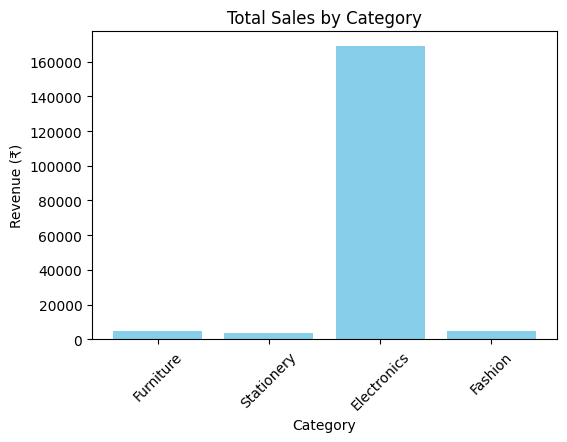

In [0]:
# Step 8: Visualization

# Convert Spark DataFrame to Pandas for visualization
import pandas as pd
import matplotlib.pyplot as plt

region_df = orders_total_df.groupBy("category").sum("total_price").toPandas()

# Create bar chart for total sales by category
plt.figure(figsize=(6,4))
plt.bar(region_df["category"], region_df["sum(total_price)"], color="skyblue")
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Revenue (₹)")
plt.xticks(rotation=45)
plt.show()
